In [1]:
import cv2
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.fftpack import dct
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

In [2]:
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras import backend
from math import pi
from math import cos
from math import floor

# Snapshot Ensemble

In [4]:
# snapshot ensemble with custom learning rate schedule
class SnapshotEnsemble(Callback):
	# constructor
	def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
		self.epochs = n_epochs
		self.cycles = n_cycles
		self.lr_max = lrate_max
		self.lrates = list()

	# calculate learning rate for epoch
	def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
		epochs_per_cycle = floor(n_epochs/n_cycles)
		cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
		return lrate_max/2 * (cos(cos_inner) + 1)

	# calculate and set learning rate at the start of the epoch
	def on_epoch_begin(self, epoch, logs={}):
		# calculate learning rate
		lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
		# set learning rate
		backend.set_value(self.model.optimizer.lr, lr)
		# log value
		self.lrates.append(lr)

	# save models at the end of each cycle
	def on_epoch_end(self, epoch, logs={}):
		# check if we can save model
		epochs_per_cycle = floor(self.epochs / self.cycles)
		if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
			# save model to file
			filename = "snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
			self.model.save(filename)
			print('>saved snapshot %s, epoch %d' % (filename, epoch))

# Load dataset

In [2]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/test',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=False,
                                                   batch_size = 64)

Found 7000 images belonging to 20 classes.
Found 3000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.


# DenseNet121

In [6]:
input_layer = K.Input(shape=(160,160,3))
effnet_model = K.applications.DenseNet121(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in effnet_model.layers:
    layer.trainable = False
for i, layer in enumerate(effnet_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 zero_padding2d - False
2 conv1/conv - False
3 conv1/bn - False
4 conv1/relu - False
5 zero_padding2d_1 - False
6 pool1 - False
7 conv2_block1_0_bn - False
8 conv2_block1_0_relu - False
9 conv2_block1_1_conv - False
10 conv2_block1_1_bn - False
11 conv2_block1_1_relu - False
12 conv2_block1_2_conv - False
13 conv2_block1_concat - False
14 conv2_block2_0_bn - False
15 conv2_block2_0_relu - False
16 conv2_block2_1_conv - False
17 conv2_block2_1_bn - False
18 conv2_block2_1_relu - False
19 conv2_block2_2_conv - False
20 conv2_block2_concat - False
21 conv2_block3_0_bn - False
22 conv2_block3_0_relu - False
23 conv2_block3_1_conv - False
24 conv2_block3_1_bn - False
25 conv2_block3_1_relu - False
26 conv2_block3_2_conv - False
27 conv2_block3_concat - False
28 conv2_block4_0_bn - False
29 conv2_block4_0_relu - False
30 conv2_block4_1_conv - False
31 conv2_block4_1_bn - False
32 conv2_block4_1_relu - False
33 conv2_block4_2_conv - False
34 conv2_block4_concat - False
35 c

# CBAM 

In [7]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape
    ## Shared layers
    l1 = K.layers.Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = K.layers.Dense(channel, use_bias=False)
    ## Global Average Pooling
    x1 = K.layers.GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)
    ## Global Max Pooling
    x2 = K.layers.GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)
    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = K.layers.Activation("sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)
    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)
    ## Concatenat both the features
    feats = K.layers.Concatenate()([x1, x2])
    ## Conv layer
    feats = K.layers.Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

In [18]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

In [9]:
inputs = K.layers.Input(shape=(160,160,3), name="image") 

resnet50 = effnet_model(inputs)
cbam_lay = cbam(resnet50)
flat = K.layers.GlobalAveragePooling2D()(cbam_lay)
output = K.layers.Dense(20, activation='softmax')(flat)

model = K.Model(inputs=inputs, outputs=output)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet121 (Functional)       (None, 5, 5, 1024)   7037504     ['image[0][0]']                  
                                                                                                  
 global_average_pooling2d (Glob  (None, 1024)        0           ['densenet121[0][0]']            
 alAveragePooling2D)                                                                              
                                                                                              

C:\Users\SAPTARSHI PANI\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training

In [10]:
n_epochs = 100
n_cycles = n_epochs / 20
ca = SnapshotEnsemble(n_epochs, n_cycles, 0.01)

history = model.fit(train_dataset,
                    epochs = n_epochs,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[ca],
                    shuffle = True)

Epoch 1/100
110/110 [==============================] - 8799s 80s/step - loss: 0.8288 - accuracy: 0.7389 - precision: 0.8622 - recall: 0.6000 - auc: 0.9820 - f1_score: 0.6660 - val_loss: 0.4820 - val_accuracy: 0.8290 - val_precision: 0.8691 - val_recall: 0.7853 - val_auc: 0.9929 - val_f1_score: 0.8245
Epoch 2/100
110/110 [==============================] - 415s 4s/step - loss: 0.3053 - accuracy: 0.8987 - precision: 0.9215 - recall: 0.8674 - auc: 0.9976 - f1_score: 0.8932 - val_loss: 0.5004 - val_accuracy: 0.8153 - val_precision: 0.8384 - val_recall: 0.7903 - val_auc: 0.9909 - val_f1_score: 0.8135
Epoch 3/100
110/110 [==============================] - 279s 3s/step - loss: 0.2169 - accuracy: 0.9326 - precision: 0.9471 - recall: 0.9156 - auc: 0.9988 - f1_score: 0.9311 - val_loss: 0.4490 - val_accuracy: 0.8393 - val_precision: 0.8583 - val_recall: 0.8220 - val_auc: 0.9919 - val_f1_score: 0.8396
Epoch 4/100
110/110 [==============================] - 279s 3s/step - loss: 0.1815 - accuracy: 0.9

Epoch 28/100
110/110 [==============================] - 280s 3s/step - loss: 0.0465 - accuracy: 0.9863 - precision: 0.9880 - recall: 0.9850 - auc: 1.0000 - f1_score: 0.9863 - val_loss: 0.5194 - val_accuracy: 0.8630 - val_precision: 0.8700 - val_recall: 0.8590 - val_auc: 0.9829 - val_f1_score: 0.8645
Epoch 29/100
110/110 [==============================] - 276s 3s/step - loss: 0.0411 - accuracy: 0.9904 - precision: 0.9918 - recall: 0.9897 - auc: 1.0000 - f1_score: 0.9908 - val_loss: 0.5449 - val_accuracy: 0.8703 - val_precision: 0.8753 - val_recall: 0.8653 - val_auc: 0.9808 - val_f1_score: 0.8702
Epoch 30/100
110/110 [==============================] - 279s 3s/step - loss: 0.0406 - accuracy: 0.9894 - precision: 0.9908 - recall: 0.9884 - auc: 1.0000 - f1_score: 0.9897 - val_loss: 0.5034 - val_accuracy: 0.8720 - val_precision: 0.8777 - val_recall: 0.8683 - val_auc: 0.9831 - val_f1_score: 0.8731
Epoch 31/100
110/110 [==============================] - 274s 2s/step - loss: 0.0361 - accuracy: 0

Epoch 81/100
110/110 [==============================] - 279s 3s/step - loss: 0.0386 - accuracy: 0.9869 - precision: 0.9874 - recall: 0.9864 - auc: 0.9998 - f1_score: 0.9865 - val_loss: 0.7297 - val_accuracy: 0.8693 - val_precision: 0.8712 - val_recall: 0.8677 - val_auc: 0.9734 - val_f1_score: 0.8694
Epoch 82/100
110/110 [==============================] - 279s 3s/step - loss: 0.0539 - accuracy: 0.9811 - precision: 0.9818 - recall: 0.9800 - auc: 0.9996 - f1_score: 0.9808 - val_loss: 0.7801 - val_accuracy: 0.8663 - val_precision: 0.8686 - val_recall: 0.8657 - val_auc: 0.9705 - val_f1_score: 0.8671
Epoch 83/100
110/110 [==============================] - 279s 3s/step - loss: 0.0460 - accuracy: 0.9836 - precision: 0.9847 - recall: 0.9831 - auc: 0.9997 - f1_score: 0.9838 - val_loss: 0.7265 - val_accuracy: 0.8690 - val_precision: 0.8711 - val_recall: 0.8653 - val_auc: 0.9727 - val_f1_score: 0.8683
Epoch 84/100
110/110 [==============================] - 275s 3s/step - loss: 0.0289 - accuracy: 0

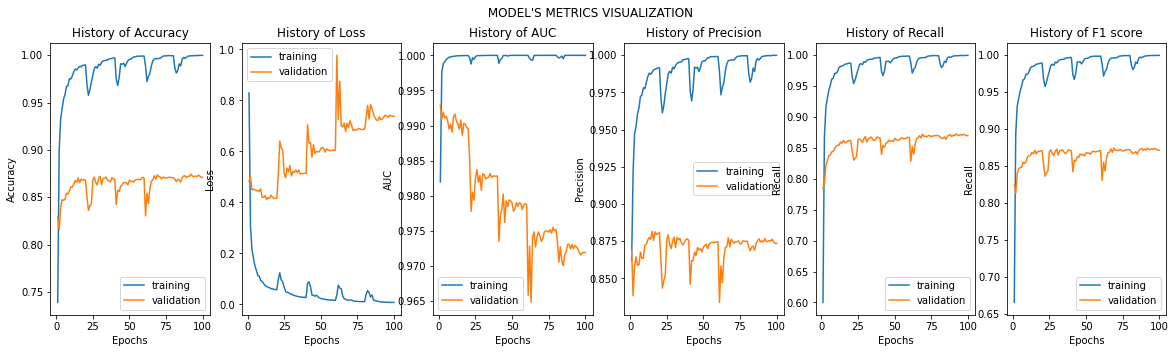

In [11]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall,f1_score,val_f1_score):
    
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])

    ax6.plot(range(1, len(f1_score) + 1), f1_score)
    ax6.plot(range(1, len(val_f1_score) + 1), val_f1_score)
    ax6.set_title('History of F1 score')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('Recall')
    ax6.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['recall'],history.history['val_recall'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [23]:
model.layers[-2].output

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'global_average_pooling2d_1')>

# Testing

In [4]:
model = K.models.load_model("snapshot_model_1.h5", custom_objects={"f1_score": f1_score})
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
print("Testing Loss:")
print(loss)
print("Testing Accuracy:")
print(accuracy)
print("Testing Precision:")
print(precision)
print("Testing Recall:")
print(recall)
print("Testing F1-Score:")
print(f1_score)
print("Testing AUC:")
print(auc)

32/32 [==============================] - 109s 3s/step - loss: 0.4421 - accuracy: 0.8745 - precision: 0.8854 - recall: 0.8655 - auc: 0.9863 - f1_score: 0.8743
Testing Loss:
0.4421226978302002
Testing Accuracy:
0.8744999766349792
Testing Precision:
0.8854219913482666
Testing Recall:
0.8654999732971191
Testing F1-Score:
0.8742538690567017
Testing AUC:
0.9863376617431641


C:\Users\aroy8\AppData\Local\Temp/ipykernel_16036/3580747851.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1157 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix


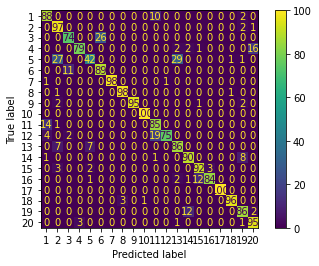

Classification Report
              precision    recall  f1-score   support

           1       0.81      0.88      0.85       100
           2       0.70      0.97      0.82       100
           3       0.85      0.74      0.79       100
           4       0.96      0.79      0.87       100
           5       0.81      0.42      0.55       100
           6       0.77      0.89      0.83       100
           7       1.00      0.98      0.99       100
           8       0.97      0.98      0.98       100
           9       1.00      0.95      0.97       100
          10       0.99      1.00      1.00       100
          11       0.74      0.85      0.79       100
          12       0.99      0.75      0.85       100
          13       0.72      0.86      0.78       100
          14       0.86      0.90      0.88       100
          15       0.87      0.92      0.89       100
          16       0.97      0.84      0.90       100
          17       1.00      1.00      1.00       100
     

In [5]:
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))

In [8]:
model = K.models.load_model("snapshot_model_2.h5", custom_objects={"f1_score": f1_score})
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
print("Testing Loss:")
print(loss)
print("Testing Accuracy:")
print(accuracy)
print("Testing Precision:")
print(precision)
print("Testing Recall:")
print(recall)
print("Testing F1-Score:")
print(f1_score)
print("Testing AUC:")
print(auc)

32/32 [==============================] - 129s 4s/step - loss: 0.5428 - accuracy: 0.8715 - precision: 0.8770 - recall: 0.8665 - auc: 0.9819 - f1_score: 0.8741
Testing Loss:
0.5427535176277161
Testing Accuracy:
0.8715000152587891
Testing Precision:
0.8770242929458618
Testing Recall:
0.8665000200271606
Testing F1-Score:
0.8741294741630554
Testing AUC:
0.9819046854972839


C:\Users\aroy8\AppData\Local\Temp/ipykernel_16036/3580747851.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1157 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix


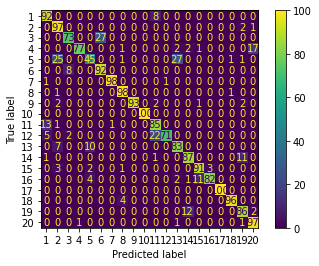

Classification Report
              precision    recall  f1-score   support

           1       0.82      0.92      0.87       100
           2       0.71      0.97      0.82       100
           3       0.88      0.73      0.80       100
           4       0.99      0.77      0.87       100
           5       0.74      0.45      0.56       100
           6       0.77      0.92      0.84       100
           7       0.99      0.98      0.98       100
           8       0.93      0.98      0.96       100
           9       1.00      0.93      0.96       100
          10       1.00      1.00      1.00       100
          11       0.72      0.85      0.78       100
          12       0.99      0.71      0.83       100
          13       0.72      0.83      0.77       100
          14       0.85      0.87      0.86       100
          15       0.88      0.91      0.89       100
          16       0.96      0.82      0.89       100
          17       1.00      1.00      1.00       100
     

In [9]:
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))

In [12]:
model = K.models.load_model("snapshot_model_3.h5", custom_objects={"f1_score": f1_score})
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
print("Testing Loss:")
print(loss)
print("Testing Accuracy:")
print(accuracy)
print("Testing Precision:")
print(precision)
print("Testing Recall:")
print(recall)
print("Testing F1-Score:")
print(f1_score)
print("Testing AUC:")
print(auc)

32/32 [==============================] - 119s 4s/step - loss: 0.6185 - accuracy: 0.8705 - precision: 0.8750 - recall: 0.8680 - auc: 0.9771 - f1_score: 0.8741
Testing Loss:
0.61851966381073
Testing Accuracy:
0.8705000281333923
Testing Precision:
0.875
Testing Recall:
0.8679999709129333
Testing F1-Score:
0.8741267323493958
Testing AUC:
0.977145791053772


C:\Users\aroy8\AppData\Local\Temp/ipykernel_16036/3580747851.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1157 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix


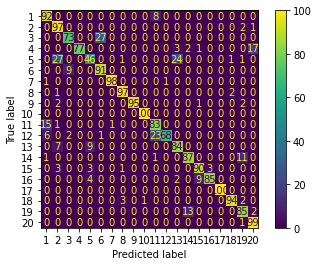

Classification Report
              precision    recall  f1-score   support

           1       0.80      0.92      0.86       100
           2       0.70      0.97      0.82       100
           3       0.87      0.73      0.79       100
           4       1.00      0.77      0.87       100
           5       0.74      0.46      0.57       100
           6       0.76      0.91      0.83       100
           7       0.99      0.98      0.98       100
           8       0.95      0.97      0.96       100
           9       1.00      0.95      0.97       100
          10       0.99      1.00      1.00       100
          11       0.72      0.83      0.77       100
          12       0.99      0.68      0.80       100
          13       0.74      0.84      0.79       100
          14       0.85      0.87      0.86       100
          15       0.89      0.90      0.90       100
          16       0.97      0.85      0.90       100
          17       1.00      1.00      1.00       100
     

In [13]:
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))

In [15]:
model = K.models.load_model("snapshot_model_4.h5", custom_objects={"f1_score": f1_score})
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
print("Testing Loss:")
print(loss)
print("Testing Accuracy:")
print(accuracy)
print("Testing Precision:")
print(precision)
print("Testing Recall:")
print(recall)
print("Testing F1-Score:")
print(f1_score)
print("Testing AUC:")
print(auc)

32/32 [==============================] - 134s 4s/step - loss: 0.7145 - accuracy: 0.8665 - precision: 0.8713 - recall: 0.8635 - auc: 0.9739 - f1_score: 0.8701
Testing Loss:
0.7145311832427979
Testing Accuracy:
0.8665000200271606
Testing Precision:
0.8713420629501343
Testing Recall:
0.8634999990463257
Testing F1-Score:
0.8700775504112244
Testing AUC:
0.9738753437995911


C:\Users\aroy8\AppData\Local\Temp/ipykernel_16036/3580747851.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1157 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix


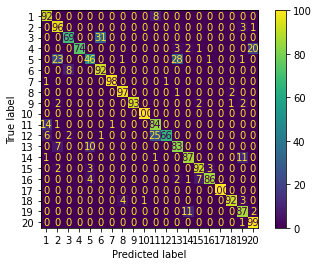

Classification Report
              precision    recall  f1-score   support

           1       0.81      0.92      0.86       100
           2       0.73      0.96      0.83       100
           3       0.87      0.69      0.77       100
           4       1.00      0.74      0.85       100
           5       0.73      0.46      0.56       100
           6       0.74      0.92      0.82       100
           7       0.99      0.98      0.98       100
           8       0.95      0.97      0.96       100
           9       1.00      0.93      0.96       100
          10       0.99      1.00      1.00       100
          11       0.71      0.84      0.77       100
          12       0.99      0.66      0.79       100
          13       0.71      0.83      0.76       100
          14       0.86      0.87      0.87       100
          15       0.90      0.92      0.91       100
          16       0.96      0.86      0.91       100
          17       1.00      1.00      1.00       100
     

In [16]:
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))

In [19]:
model = K.models.load_model("snapshot_model_5.h5", custom_objects={"f1_score": f1_score})
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
print("Testing Loss:")
print(loss)
print("Testing Accuracy:")
print(accuracy)
print("Testing Precision:")
print(precision)
print("Testing Recall:")
print(recall)
print("Testing F1-Score:")
print(f1_score)
print("Testing AUC:")
print(auc)

32/32 [==============================] - 126s 4s/step - loss: 0.7920 - accuracy: 0.8620 - precision: 0.8646 - recall: 0.8590 - auc: 0.9701 - f1_score: 0.8647
Testing Loss:
0.7919840216636658
Testing Accuracy:
0.8619999885559082
Testing Precision:
0.8646200299263
Testing Recall:
0.859000027179718
Testing F1-Score:
0.8646818995475769
Testing AUC:
0.9700873494148254


C:\Users\aroy8\AppData\Local\Temp/ipykernel_16036/3580747851.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1157 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix


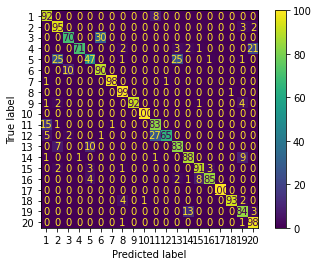

Classification Report
              precision    recall  f1-score   support

           1       0.80      0.92      0.86       100
           2       0.72      0.95      0.82       100
           3       0.85      0.70      0.77       100
           4       0.99      0.71      0.83       100
           5       0.73      0.47      0.57       100
           6       0.74      0.90      0.81       100
           7       0.99      0.98      0.98       100
           8       0.92      0.99      0.95       100
           9       1.00      0.92      0.96       100
          10       0.99      1.00      1.00       100
          11       0.70      0.83      0.76       100
          12       0.98      0.65      0.78       100
          13       0.73      0.83      0.78       100
          14       0.85      0.88      0.86       100
          15       0.90      0.91      0.91       100
          16       0.96      0.85      0.90       100
          17       1.00      1.00      1.00       100
     

In [20]:
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))